**OCD Patient Dataset: Demographics & Clinical Data**

The "OCD Patient Dataset: Demographics & Clinical Data" provides a detailed profile of 1,500 individuals diagnosed with Obsessive-Compulsive Disorder (OCD), offering valuable insights into both demographic and clinical aspects. The dataset captures essential demographic details such as age, gender, ethnicity, marital status, and education level, giving a comprehensive overview of the patient population.

Clinically, the dataset includes information on the date of diagnosis, symptom duration, and any previous psychiatric diagnoses, which help contextualize each patient's medical history. It further categorizes OCD symptoms into obsessions and compulsions, with severity measured using Yale-Brown Obsessive-Compulsive Scale (Y-BOCS) scores for both types of symptoms.

In addition, the dataset highlights any co-occurring mental health conditions such as depression or anxiety and provides detailed information on the medications prescribed to patients, offering a glimpse into treatment strategies. It also records whether patients have a family history of OCD, allowing for the exploration of potential genetic or environmental influences on the disorder. This dataset is a valuable resource for research into OCD’s demographic patterns, symptomatology, and treatment approaches.


In [3]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 7.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import shap
from sklearn.preprocessing import OneHotEncoder


# EDA

##dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ocd_patient_dataset.csv to ocd_patient_dataset (6).csv


In [45]:

df = pd.read_csv("ocd_patient_dataset.csv")
df.head()


,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


In [46]:
# Count the number of OCD patients diagnosed with Anxiety
anxiety_diagnosed_count = df['Anxiety Diagnosis'].sum()

print(f"Number of OCD patients diagnosed with Anxiety: {anxiety_diagnosed_count}")


Number of OCD patients diagnosed with Anxiety: YesYesNoYesNoYesNoNoYesYesNoYesYesNoNoYesNoYesNoYesYesNoNoYesNoYesNoNoNoNoYesNoYesYesNoNoYesNoNoNoNoNoNoYesNoNoNoNoYesNoYesNoYesYesNoNoNoNoNoNoYesYesYesYesYesYesYesNoNoYesNoYesYesNoNoNoNoYesNoNoNoYesYesNoNoYesNoNoYesYesYesNoNoNoYesNoYesNoNoYesNoNoYesNoNoYesNoYesYesYesNoNoYesYesNoYesNoYesYesNoNoYesNoNoYesNoYesNoNoNoNoNoYesNoYesYesNoYesYesYesYesYesNoYesNoNoYesNoNoNoYesNoYesYesNoNoYesYesYesYesYesNoYesNoNoYesYesYesYesNoYesNoYesNoNoNoNoYesNoNoYesNoYesYesYesNoYesYesNoYesYesYesYesNoNoYesYesYesNoYesYesYesYesNoYesNoYesNoYesNoYesYesNoNoNoYesNoYesYesYesNoYesYesYesYesYesYesNoNoYesYesNoYesYesYesYesYesNoYesNoYesNoYesNoNoYesYesYesNoYesYesNoYesNoYesNoNoYesYesYesYesYesNoYesNoNoNoNoYesYesNoYesYesNoYesNoNoNoYesNoYesYesNoYesNoYesNoNoYesYesNoYesYesNoNoYesNoNoYesYesYesYesYesNoNoYesNoYesNoNoYesYesNoYesYesYesNoNoNoNoNoNoYesYesYesNoYesYesNoYesYesNoYesNoNoYesYesNoNoYesYesYesYesNoNoYesYesNoYesYesNoYesNoYesNoNoNoNoYesNoYesYesNoYesYesYesNoYesNoYesYesNoYesNoYesNoYesNoY

In [6]:
df.shape

(1500, 17)

####Basic EDA

In [47]:
# Handle Missing Values
df['Previous Diagnoses'].fillna('No Previous Diagnoses', inplace=True)
df['Medications'].fillna('No Medications', inplace=True)

# Drop columns
df.drop('OCD Diagnosis Date', axis=1, inplace=True)

# Datatype
df['Depression Diagnosis'] = df['Depression Diagnosis'].map({'Yes': 1, 'No': 0})
df['Family History of OCD'] = df['Family History of OCD'].map({'Yes': 1, 'No': 0})
#df['Anxiety Diagnosis'] = df['Anxiety Diagnosis'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})


# OneHotEncode
# Compulsion Type
compulsion_types = df['Compulsion Type'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_compulsion_types = ohe.fit_transform(df[['Compulsion Type']])
encoded_column_names = [f"Compulsion_Type_{compulsion_type}" for compulsion_type in compulsion_types]
encoded_df = pd.DataFrame(encoded_compulsion_types.toarray(), columns=encoded_column_names)
df = pd.concat([df, encoded_df], axis=1)
df.drop('Compulsion Type', axis=1, inplace=True)

# Medications
medications = df['Medications'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_medications = ohe.fit_transform(df[['Medications']])
encoded_column_names = [f"Medications_{medication}" for medication in medications]
encoded_df = pd.DataFrame(encoded_medications.toarray(), columns=encoded_column_names)
df = pd.concat([df, encoded_df], axis=1)
df.drop('Medications', axis=1, inplace=True)

# One-hot encoding for Ethnicity
ethnicities = df['Ethnicity'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_ethnicities = ohe.fit_transform(df[['Ethnicity']])
encoded_ethnicity_column_names = [f"Ethnicity_{ethnicity}" for ethnicity in ethnicities]
encoded_ethnicity_df = pd.DataFrame(encoded_ethnicities.toarray(), columns=encoded_ethnicity_column_names)
df = pd.concat([df, encoded_ethnicity_df], axis=1)
df.drop('Ethnicity', axis=1, inplace=True)

# One-hot encoding for Marital Status
marital_statuses = df['Marital Status'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_marital_statuses = ohe.fit_transform(df[['Marital Status']])
encoded_marital_status_column_names = [f"Marital Status_{status}" for status in marital_statuses]
encoded_marital_status_df = pd.DataFrame(encoded_marital_statuses.toarray(), columns=encoded_marital_status_column_names)
df = pd.concat([df, encoded_marital_status_df], axis=1)
df.drop('Marital Status', axis=1, inplace=True)

# One-hot encoding for Education Level
education_levels = df['Education Level'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_education_levels = ohe.fit_transform(df[['Education Level']])
encoded_education_level_column_names = [f"Education Level_{level}" for level in education_levels]
encoded_education_level_df = pd.DataFrame(encoded_education_levels.toarray(), columns=encoded_education_level_column_names)
df = pd.concat([df, encoded_education_level_df], axis=1)
df.drop('Education Level', axis=1, inplace=True)

# One-hot encoding for Previous Diagnoses
previous_diagnoses = df['Previous Diagnoses'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_previous_diagnoses = ohe.fit_transform(df[['Previous Diagnoses']])
encoded_previous_diagnosis_column_names = [f"Previous Diagnoses_{diagnosis}" for diagnosis in previous_diagnoses]
encoded_previous_diagnosis_df = pd.DataFrame(encoded_previous_diagnoses.toarray(), columns=encoded_previous_diagnosis_column_names)
df = pd.concat([df, encoded_previous_diagnosis_df], axis=1)
df.drop('Previous Diagnoses', axis=1, inplace=True)

# One-hot encoding for Obsession Type
obsession_types = df['Obsession Type'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_obsession_types = ohe.fit_transform(df[['Obsession Type']])
encoded_obsession_type_column_names = [f"Obsession Type_{type}" for type in obsession_types]
encoded_obsession_type_df = pd.DataFrame(encoded_obsession_types.toarray(), columns=encoded_obsession_type_column_names)
df = pd.concat([df, encoded_obsession_type_df], axis=1)
df.drop('Obsession Type', axis=1, inplace=True)

# One-hot encoding for Anxiety Diagnosis
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_anxiety_diagnosis = ohe.fit_transform(df[['Anxiety Diagnosis']])
encoded_anxiety_column_names = [f"Anxiety_Diagnosis_{diagnosis}" for diagnosis in ohe.categories_[0]]
encoded_anxiety_df = pd.DataFrame(encoded_anxiety_diagnosis.toarray(), columns=encoded_anxiety_column_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, encoded_anxiety_df], axis=1)

# Drop the original Anxiety Diagnosis column
df.drop('Anxiety Diagnosis', axis=1, inplace=True)

# Print the data types to confirm changes
print(df.dtypes)



Patient ID                                    int64
Age                                           int64
Gender                                        int64
Duration of Symptoms (months)                 int64
Family History of OCD                         int64
Y-BOCS Score (Obsessions)                     int64
Y-BOCS Score (Compulsions)                    int64
Depression Diagnosis                          int64
Compulsion_Type_Checking                    float64
Compulsion_Type_Washing                     float64
Compulsion_Type_Ordering                    float64
Compulsion_Type_Praying                     float64
Compulsion_Type_Counting                    float64
Medications_SNRI                            float64
Medications_SSRI                            float64
Medications_Benzodiazepine                  float64
Medications_No Medications                  float64
Ethnicity_African                           float64
Ethnicity_Hispanic                          float64
Ethnicity_As

/var/folders/2w/1kvqm7xn4jq08r7gfmxbn8r40000gn/T/ipykernel_86784/2547912057.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Previous Diagnoses'].fillna('No Previous Diagnoses', inplace=True)
/var/folders/2w/1kvqm7xn4jq08r7gfmxbn8r40000gn/T/ipykernel_86784/2547912057.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [48]:

# Count the number of OCD patients diagnosed with anxiety
anxiety_diagnosis_count = df['Anxiety_Diagnosis_Yes'].sum()

print(f'Number of OCD patients diagnosed with anxiety: {anxiety_diagnosis_count}')


Number of OCD patients diagnosed with anxiety: 751.0


## Analytical questions


### What is the average age of OCD patients in the dataset? (optional question)

In [9]:
#code:

# Calculate the average age of OCD patients
average_age = df['Age'].mean()

print(f"The average age of OCD patients is {average_age:.2f} years.")




The average age of OCD patients is 46.78 years.


###  What is the gender distribution of OCD patients? (optional question)

/var/folders/2w/1kvqm7xn4jq08r7gfmxbn8r40000gn/T/ipykernel_86784/1076135918.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette='Set2')


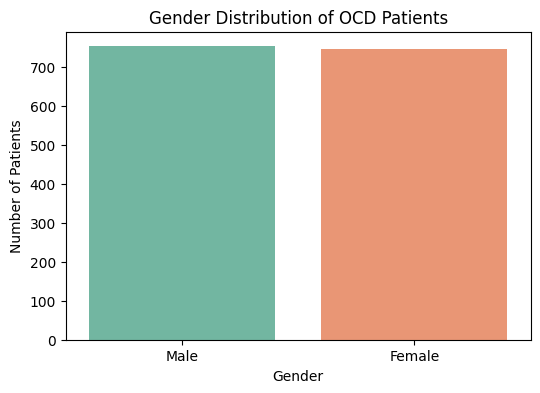

In [11]:
#code:
# Calculate the gender distribution of OCD patients
gender_distribution = df['Gender'].value_counts()

# Mapping back 0 and 1 to 'Male' and 'Female'
gender_distribution.index = gender_distribution.index.map({0: 'Male', 1: 'Female'})

# Now plot the bar chart for gender distribution
plt.figure(figsize=(6,4))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette='Set2')
plt.title('Gender Distribution of OCD Patients')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()



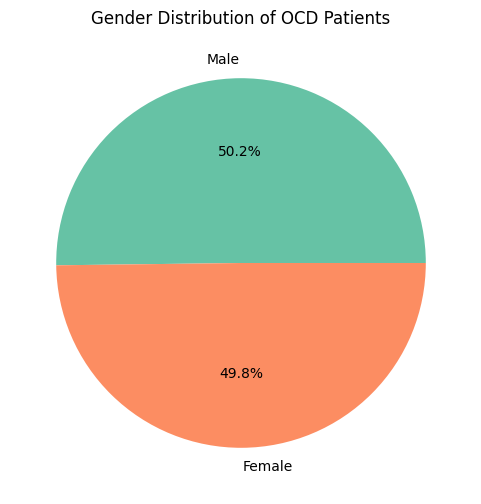

In [12]:
# Pie chart for gender distribution
plt.figure(figsize=(6,6))
plt.pie(gender_distribution.values, labels=gender_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Gender Distribution of OCD Patients')
plt.show()

### What medications are most commonly prescribed to OCD patients? (optional question)

In [13]:
# Code
# Calculate the count of each medication prescribed
medication_distribution = df.filter(like='Medications_').sum()

# Sort the medications by count in descending order
medication_distribution_sorted = medication_distribution.sort_values(ascending=False)

print(medication_distribution_sorted)

Medications_SNRI              386.0
Medications_SSRI              386.0
Medications_Benzodiazepine    376.0
Medications_No Medications    352.0
dtype: float64


/var/folders/2w/1kvqm7xn4jq08r7gfmxbn8r40000gn/T/ipykernel_86784/2179862887.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medication_distribution_sorted.index, y=medication_distribution_sorted.values, palette='Set2')


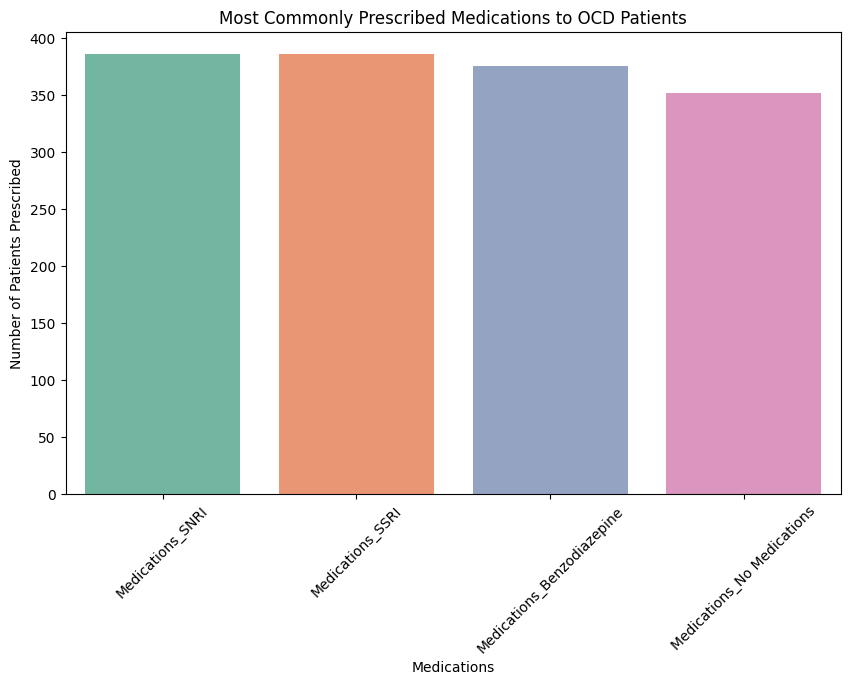

In [14]:
# Bar chart for medication distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=medication_distribution_sorted.index, y=medication_distribution_sorted.values, palette='Set2')
plt.title('Most Commonly Prescribed Medications to OCD Patients')
plt.xlabel('Medications')
plt.ylabel('Number of Patients Prescribed')
plt.xticks(rotation=45)
plt.show()


### What is the distribution of depression diagnosis (Yes/No) among OCD patients?

In [15]:
# Calculate the distribution of Depression Diagnosis
depression_distribution = df['Depression Diagnosis'].value_counts()

# Map 0 and 1 back to 'No' and 'Yes'
depression_distribution.index = depression_distribution.index.map({0: 'No', 1: 'Yes'})

print(depression_distribution)


Depression Diagnosis
Yes    772
No     728
Name: count, dtype: int64


/var/folders/2w/1kvqm7xn4jq08r7gfmxbn8r40000gn/T/ipykernel_86784/440106639.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=depression_distribution.index, y=depression_distribution.values, palette='Set2')


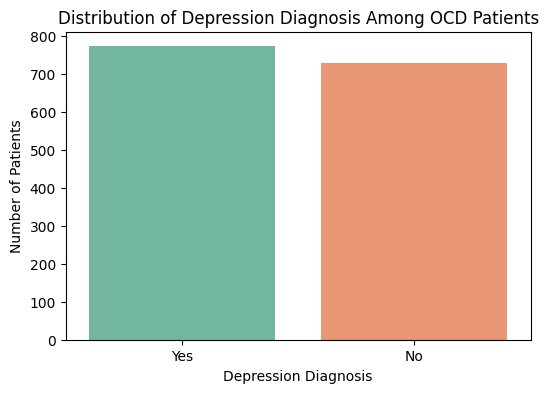

In [16]:
# Bar chart for depression diagnosis distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=depression_distribution.index, y=depression_distribution.values, palette='Set2')
plt.title('Distribution of Depression Diagnosis Among OCD Patients')
plt.xlabel('Depression Diagnosis')
plt.ylabel('Number of Patients')
plt.show()


### How many OCD patients are also diagnosed with anxiety?

In [49]:
# Count the number of OCD patients diagnosed with anxiety
anxiety_diagnosis_count = df['Anxiety_Diagnosis_Yes'].sum()

print(f'Number of OCD patients diagnosed with anxiety: {anxiety_diagnosis_count}')




Number of OCD patients diagnosed with anxiety: 751.0


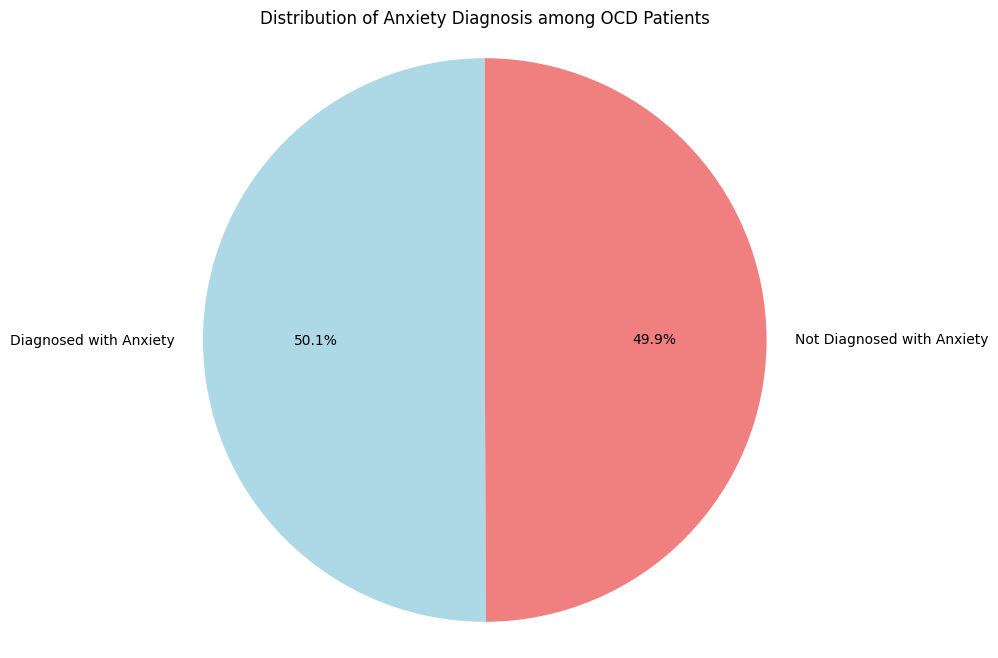

In [50]:
anxiety_counts = df[['Anxiety_Diagnosis_Yes', 'Anxiety_Diagnosis_No']].sum()


# Pie chart for anxiety diagnosis
plt.figure(figsize=(8, 8))
plt.pie(anxiety_counts, labels=['Diagnosed with Anxiety', 'Not Diagnosed with Anxiety'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Anxiety Diagnosis among OCD Patients')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


/var/folders/2w/1kvqm7xn4jq08r7gfmxbn8r40000gn/T/ipykernel_86784/1076135918.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette='Set2')


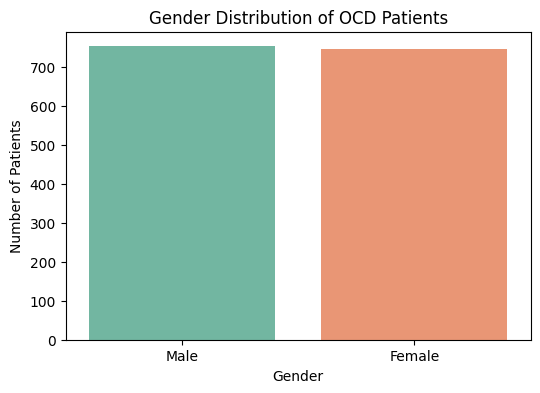

In [ ]:
#code:
# Calculate the gender distribution of OCD patients
gender_distribution = df['Gender'].value_counts()

# Mapping back 0 and 1 to 'Male' and 'Female'
gender_distribution.index = gender_distribution.index.map({0: 'Male', 1: 'Female'})

# Now plot the bar chart for gender distribution
plt.figure(figsize=(6,4))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette='Set2')
plt.title('Gender Distribution of OCD Patients')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()



### What are the average Y-BOCS obsession and compulsion scores for OCD patients? (check against other compulsion question)

In [23]:
# Calculate average Y-BOCS Obsession and Compulsion scores
average_obsession_score = df['Y-BOCS Score (Obsessions)'].mean()
average_compulsion_score = df['Y-BOCS Score (Compulsions)'].mean()

print(f"Average Y-BOCS Obsession Score: {average_obsession_score:.2f}")
print(f"Average Y-BOCS Compulsion Score: {average_compulsion_score:.2f}")


Average Y-BOCS Obsession Score: 20.05
Average Y-BOCS Compulsion Score: 19.63


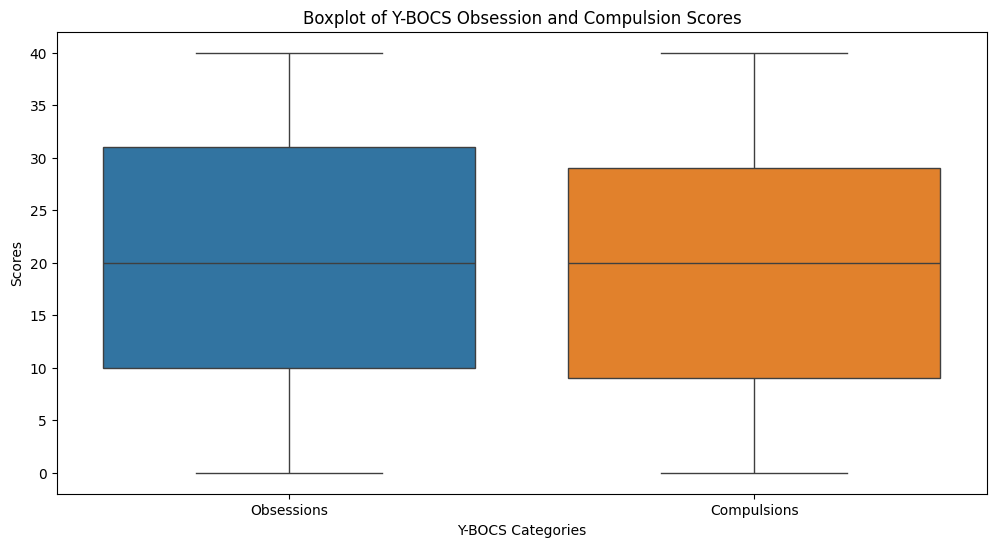

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create a boxplot for Y-BOCS scores
sns.boxplot(data=df[['Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)']])
plt.title('Boxplot of Y-BOCS Obsession and Compulsion Scores')
plt.xlabel('Y-BOCS Categories')
plt.ylabel('Scores')
plt.xticks(ticks=[0, 1], labels=['Obsessions', 'Compulsions'])  # Custom x-tick labels

# Show the plot
plt.show()
